In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [3]:
out_dir = '../models/'+exp_pref
with open(out_dir+'/summary.pkl','rb') as f:
    data = pkl.load(f)
n1=6
n2=7
data[n1+5,n2+5][0]

[FrankCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [4]:
import warnings
import sys
import traceback
from tqdm import tqdm
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
    
def get_model(n1,n2,likelihoods,device):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
            return 0
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        return model
    else:
        print('Weights file {} not found.'.format(get_weights_filename))
        return 0
        
def measure_MI(model,points,samp_mc_size=10000):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([5])) #[samples_f, copulas, positions]
    f_mean = model(points).mean.unsqueeze(0)
    # now add mean f to a set of f samples
    fs = torch.cat((fs,f_mean),0) #[samples_f + 1, copulas, positions]

    copula = model.likelihood(fs)
    MIs = copula.entropy()
    MI_mean = MIs[-1]
    MIs = MIs[:-1]

    return (MI_mean,MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,20)
        
print(data[n1+5,n2+5][1])

%time model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (ym, y, dy) = measure_MI(model, points)

Frank
['/home/nina/models/ST263_Day4/model_6-7.pth']
CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 4.84 ms
CPU times: user 46.2 s, sys: 726 ms, total: 47 s
Wall time: 1.55 s


(-0.5, 0)

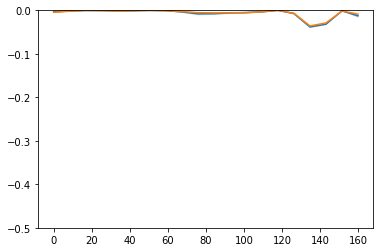

In [5]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)

In [6]:
import utils
path_exp = '/home/nina/VRData/Processing/pkls'
X,_ = utils.load_experimental_data(path_exp, animal, day_name, 0, 1)

(array([1.24099761, 0.78062753, 0.78062753, 0.78062753, 0.66053099,
        0.86069189, 0.70056317, 1.00080453, 1.46117461, 1.74139988]),
 array([0.        , 0.09991961, 0.19983922, 0.29975884, 0.39967845,
        0.49959806, 0.59951767, 0.69943728, 0.7993569 , 0.89927651,
        0.99919612]),
 <a list of 10 Patch objects>)

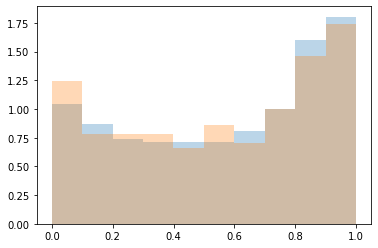

In [7]:
plt.hist(X,density=True,alpha=0.3)
plt.hist(np.random.choice(X.flatten(),500),density=True,alpha=0.3)

In [10]:
device = torch.device('cuda:0')
f_mc_size = 5
model = get_model(n1, n2, data[n1+5,n2+5][0], device) 
S = torch.tensor(X).float().squeeze().to(device)
with torch.no_grad():
    Fs = model(S).rsample(torch.Size([f_mc_size])) 
    #[samples_f, copulas, stimuli(positions)]
print(S.shape)

['/home/nina/models/ST263_Day4/model_6-7.pth']
torch.Size([22384])


In [11]:
%time MI,sem=model.likelihood.stimMI(S,Fs,s_mc_size=200,r_mc_size=20,sR_mc_size=5000,sem_tol=5*1e-3)
#,sem_tol=1e-3,  
print(f"{MI.mean().item():.3}±{MI.std().item():.3}")

Start calculating p(r) 0
Finished in 2 steps
0.00814,0.000681,0.00746,                    0.804,0.17
CPU times: user 318 ms, sys: 116 ms, total: 434 ms
Wall time: 431 ms
0.00746±0.00432


In [16]:
sem.max()/(MI.max()-MI.min())

tensor(0.3659, device='cuda:0')